In [1]:
from chordextractor import ChordExtractor
import chordgraph

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.stats import itemfreq
import time
import os
import pickle
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import Lasso
%matplotlib inline 

## Functions to get vectors from MIDI files for chords, pitches and durations

In [2]:
# Get file names of type type_ in all the subdirectories of the path
def get_filenames(path, type_ = None):
    if type_ == None:
        return sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), [])
    else:
        return filter(lambda f: f.endswith(type_), sum(map(lambda walks: (map(lambda name: os.path.join(walks[0], name),
                                                                           walks[2])), os.walk(path)), []))
       
# Getting set of all possible chords after normalization        
chord_encode =  {k: i for k, i in zip(chordgraph.ChordGraph().normalized_chords,
                                      range(len(chordgraph.ChordGraph().normalized_chords)))}        
        
# Enumerating chords for processing and storage optimization
def encode_chords(chords, encoder = None, type_ = None):
    if type_ == 'chord':
        return map(lambda chord: encoder[chord], chords)
    return chords

# Generate all sequences of 4 consecutive notes
def get_sequences(data):
    #for seq in imap(lambda i: [data[i], data[i+1], data[i+2], data[i+3]], range(0, len(data)-3)):
    #    yield seq
    return map(lambda i: [data[i], data[i+1], data[i+2], data[i+3]], range(0, len(data)-3))

# Returns index of the note quartet in the vector
def notestoindex(numbers, num):
    return reduce(lambda x, y: num*x+y, numbers)

# Build vector of ocurrences of note quartets
def build_vector(sequence, num):
    vector = [0] * num**4
    seqs_indexed = map(notestoindex, sequence, [num]*len(sequence))
    for x in itemfreq(seqs_indexed):
        vector[x[0]] = x[1]
    return vector

def vector_from_file(filename_):
    extractor = ChordExtractor(filename_)
    chord_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedChords(), chord_encode, 'chord')),14)
    pitch_vector = build_vector(get_sequences(encode_chords(extractor.getNormalizedPitches())),12)
    return chord_vector, pitch_vector

#normalizedChords = extractor.getNormalizedChords()
#normalizedPitches = extractor.getNormalizedPitches()
# normalizedDurations = extractor.getChordDurations()

# Build vectors from MIDI files and pickle them
def vectors_from_files(path, class_, count):
    files = map(lambda x: x[0], sorted(map(lambda f: [f, os.stat(f).st_size], get_filenames(path)), 
                                   key = lambda x: x[1]))[:count]
    c = 0
    for name in files:
        with open(str(class_)+str(c)+".dat", "wb") as f:
            pickle.dump(vector_from_file(name), f)
            print name+" done"
            print str(class_)+str(c)+".dat"
            c+=1
    #X = map(lambda name: vector_from_file(name), files)
    return True

# Loading vectors from pickles
def get_vectors_from_pickles(path):
    class0 = filter(lambda x: x.split('/')[-1][0]=='0', get_filenames(path, ".dat"))
    class1 = filter(lambda x: x.split('/')[-1][0]=='1', get_filenames(path, ".dat"))
    vector0 = []
    vector1 = []
    for name in class0:
        with open(name, "rb") as f:
            vector0.append(pickle.load(f))
    for name in class1:
        with open(name, "rb") as f:
            vector1.append(pickle.load(f))
    return vector0, vector1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Rename files, get vectors

In [124]:
path_to_class0 = './70s/'
path_to_class1 = './80s/'
# Renaming 50s and 60s .kar to .mid
map1 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
           get_filenames(path_to_class0))
map2 = map(lambda name: os.rename(name, name.replace(".kar", ".mid").replace(".KAR", ".mid")), 
           get_filenames(path_to_class1))

# Identifying the smallest directory in terms of number of midis
midi_count = min(len(get_filenames(path_to_class0)), len(get_filenames(path_to_class1)))
midi_count

193

In [195]:
start_time = time.time()
vectors0 = vectors_from_files(path_to_class0, 0, 72)
print "Class 0 is done"
print("--- %s seconds ---" % (time.time() - start_time))
vectors1 = vectors_from_files(path_to_class1, 1, 72)
print "Class 1 is done"
print("--- %s seconds ---" % (time.time() - start_time))

In [162]:
# extractor = ChordExtractor(fileName="albeniz.mid")
# normalizedChords = extractor.getNormalizedChords()
# normalizedPitches = extractor.getNormalizedPitches()
# normalizedDurations = extractor.getChordDurations()
# type(normalizedDurations)

In [3]:
# Separating chords and pitches
vector0, vector1 = get_vectors_from_pickles('vectors')
chordvector0 = map(lambda x: x[0], vector0)
chordvector1 = map(lambda x: x[0], vector1)
pitchvector0 = map(lambda x: x[1], vector0)
pitchvector1 = map(lambda x: x[1], vector1)

# SVM

## Chords

In [4]:
# Merging the vectors together and extracting the attributes and the label
X = chordvector0+chordvector1
Y = [0]*72+[1]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state = 25)

In [5]:
print len(X_train), len(Y_train)
print len(X_valid), len(Y_valid)
print len(X_test), len(Y_test)

97 97
25 25
22 22


In [7]:
# Fitting the parameter C for the SVM model on the training / validation
# Function to train SVM on training set and to predict the validation set
def trainpredict(degree, C):
    clf = svm.SVC(kernel = 'poly', degree = degree, C = C) 
    clf.fit(X_train, Y_train)
    return (Y_valid == clf.predict(X_valid)).sum()*100/len(Y_valid), degree, C

# Function to fit poly SVMs of degrees 1 to 4 each with Cs from the list
def fitDegree_C():
    return map(lambda degree: map(trainpredict, [degree]*len(np.linspace(-10, 2*degree, 200)),
                            map(lambda c: math.exp(c), np.linspace(-10, 2*degree, 200))), range(1, 5)) 
# Each of the sublists correspond to a degree (1 to 4) and has tuples with (accuracy, degree, C)
fitted = fitDegree_C()

In [8]:
# Finding the best fit
flatten = sum(fitted, [])
# Looking for the optimal parameters
max(enumerate(flatten), key = lambda x: x[1])

(773, (92, 4, 283.79189515786703))

In [9]:
# Checkng on the test set
clf = svm.SVC(kernel = 'poly', degree = 4, C=283.79189515786703)
clf.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==clf.predict(X_train)).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==clf.predict(X_test)).sum()*100/len(Y_test))

We successfully predict the 98 percent of training data
We successfully predict the 95 percent of test data


In [10]:
def plotter():
    fig = plt.figure(figsize=(10, 8))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)
    for i in range (1, 5):
        ax = fig.add_subplot(2, 2, i)
        ax.set_title("Polynomial degree of " + str(i))
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("C")
        ax.semilogx()
        plot_ = plt.plot(map(lambda x: x[2], fitted[i-1]), map(lambda x: x[0], fitted[i-1]))
    return True

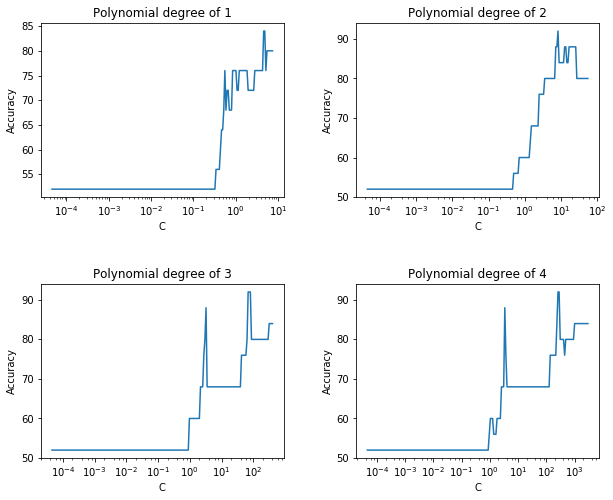

In [11]:
p = plotter()

Confusion matrix, without normalization
[[11  1]
 [ 0 10]]


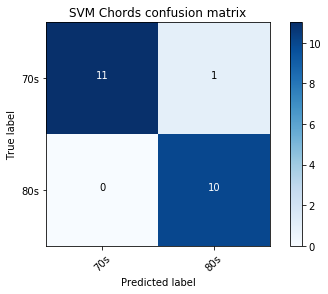

In [12]:
# Confusion matrix
Y_test
Y_predict = clf.predict(X_test)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=False,
                      title='SVM Chords confusion matrix')

Normalized confusion matrix
[[ 0.91666667  0.08333333]
 [ 0.          1.        ]]


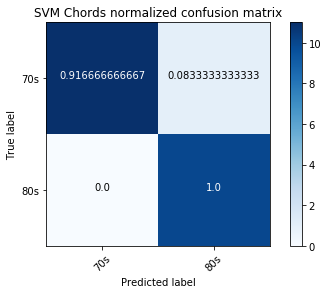

In [13]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=True,
                      title='SVM Chords normalized confusion matrix')

# SVM 

## Pitches

In [14]:
# Merging the vectors together and extracting the attributes and the label
X = pitchvector0+pitchvector1
Y = [0]*72+[1]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state = 25)

In [15]:
print len(X_train), len(Y_train)
print len(X_valid), len(Y_valid)
print len(X_test), len(Y_test)

97 97
25 25
22 22


In [16]:
# Each of the sublists correspond to a degree (1 to 4) and has tuples with (accuracy, degree, C)
fitted = fitDegree_C()

In [17]:
# Finding the best fit
flatten = sum(fitted, [])
# Looking for the optimal parameters
max(enumerate(flatten), key = lambda x: x[1])

(799, (96, 4, 2980.9579870417283))

In [18]:
# Checkng on the test set
clf = svm.SVC(kernel = 'poly', degree = 4, C=2980.9579870417283)
clf.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==clf.predict(X_train)).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==clf.predict(X_test)).sum()*100/len(Y_test))

We successfully predict the 100 percent of training data
We successfully predict the 100 percent of test data


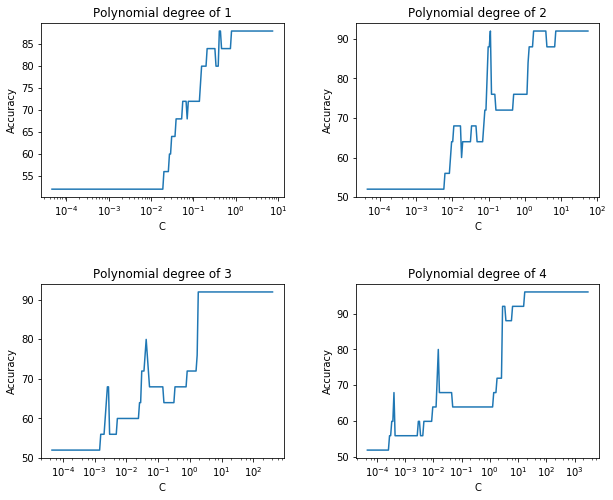

In [19]:
p = plotter()

Confusion matrix, without normalization
[[12  0]
 [ 0 10]]


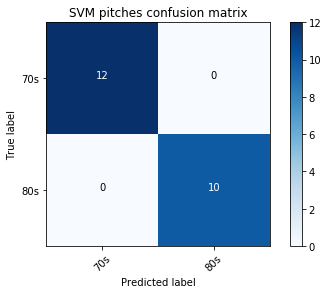

In [20]:
# Confusion matrix
Y_test
Y_predict = clf.predict(X_test)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=False,
                      title='SVM pitches confusion matrix')

Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


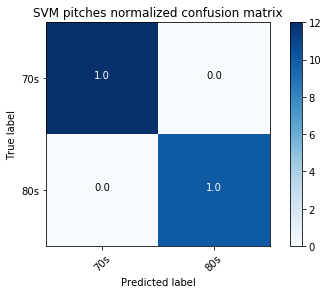

In [21]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=True,
                      title='SVM pitches normalized confusion matrix')

# SVM
## Durations

In [28]:
# Accessing durations
durationvector0, durationvector1 = get_vectors_from_pickles('durationfiles')

In [29]:
# Merging the vectors together and extracting the attributes and the label
X = durationvector0+durationvector1
Y = [0]*72+[1]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state = 25)

In [30]:
# Each of the sublists correspond to a degree (1 to 4) and has tuples with (accuracy, degree, C)
fitted = fitDegree_C()

In [31]:
# Finding the best fit
flatten = sum(fitted, [])
# Looking for the optimal parameters
max(enumerate(flatten), key = lambda x: x[1])

(64, (64, 1, 0.0021534081247821524))

In [34]:
# Checkng on the test set
clf = svm.SVC(kernel = 'poly', degree = 1, C=0.0021534081247821524)
clf.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==clf.predict(X_train)).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==clf.predict(X_test)).sum()*100/len(Y_test))

We successfully predict the 61 percent of training data
We successfully predict the 50 percent of test data


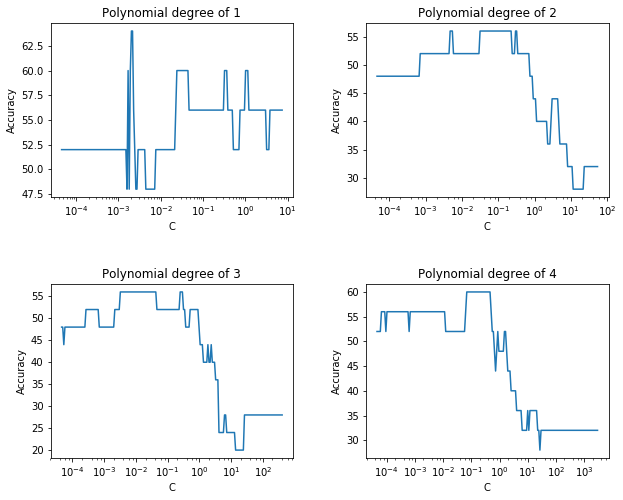

In [36]:
p = plotter()

Confusion matrix, without normalization
[[9 3]
 [8 2]]


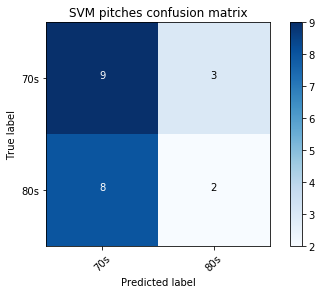

In [37]:
# Confusion matrix
Y_test
Y_predict = clf.predict(X_test)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=False,
                      title='SVM pitches confusion matrix')

Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.8   0.2 ]]


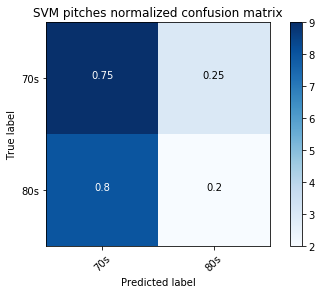

In [38]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=True,
                      title='SVM pitches normalized confusion matrix')

# Linear Regression LASSO

## Chords

In [4]:
# Merging the vectors together and extracting the attributes and the label
X = chordvector0+chordvector1
Y = [0]*72+[1]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state = 25)

In [6]:
print len(X_train), len(Y_train)
print len(X_valid), len(Y_valid)
print len(X_test), len(Y_test)

97 97
25 25
22 22


In [7]:
# Fitting the parameter alpha for the LASSO model on the training / validation
# Function to train LASSO on training set and to predict the validation set
def trainpredict_L(alpha):
    lassoreg = Lasso(alpha = alpha, normalize = False, max_iter = 1e5)
    lassoreg.fit(X_train, Y_train)
    Y_predict = np.round(lassoreg.predict(X_valid))
    return (Y_valid == Y_predict).sum()*100/len(Y_valid), alpha

# Function to fit alpha for LASSO
def fitalpha():
    return map(lambda alpha: trainpredict_L(alpha), np.linspace(0, 2, 100))

# Fitting the alpha
fitted = fitalpha()

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/home/denis/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)


In [8]:
# Looking for the optimal parameters
max(enumerate(fitted), key = lambda x: x[1])

(2, (92, 0.040404040404040407))

In [9]:
# Checkng on the test set
lassoreg = Lasso(alpha = 0.040404040404040407, normalize = False, max_iter = 1000)
lassoreg.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==np.round(lassoreg.predict(X_train))).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==np.round(lassoreg.predict(X_test))).sum()*100/len(Y_test))

We successfully predict the 98 percent of training data
We successfully predict the 86 percent of test data


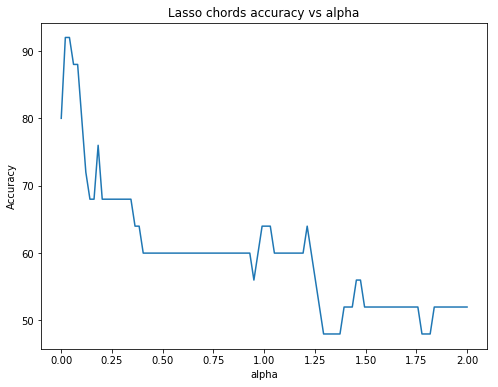

In [10]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Lasso chords accuracy vs alpha")
plot_ = plt.plot(map(lambda x: x[1], fitted), map(lambda x: x[0], fitted))

Confusion matrix, without normalization
[[ 9  3]
 [ 0 10]]


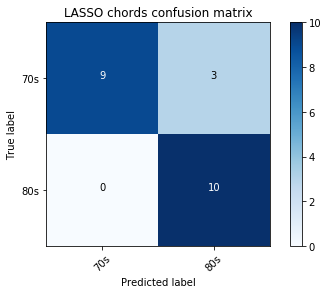

In [11]:
# Confusion matrix
Y_test
Y_predict = np.round(lassoreg.predict(X_test))
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=False,
                      title='LASSO chords confusion matrix')

Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.    1.  ]]


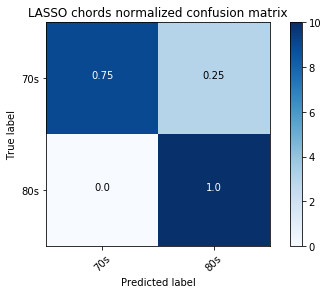

In [12]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=True,
                      title='LASSO chords normalized confusion matrix')

# Linear Regression LASSO

## Pithces

In [13]:
# Merging the vectors together and extracting the attributes and the label
X = pitchvector0+pitchvector1
Y = [0]*72+[1]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state = 25)

In [14]:
print len(X_train), len(Y_train)
print len(X_valid), len(Y_valid)
print len(X_test), len(Y_test)

97 97
25 25
22 22


In [15]:
# Fitting the alpha
fitted = fitalpha()

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [16]:
# Looking for the optimal parameters
max(enumerate(fitted), key = lambda x: x[1])

(0, (96, 0.0))

In [17]:
# Checkng on the test set
lassoreg = Lasso(alpha = 0.0, normalize = False, max_iter = 1e5)
lassoreg.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==np.round(lassoreg.predict(X_train))).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==np.round(lassoreg.predict(X_test))).sum()*100/len(Y_test))

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  app.launch_new_instance()


We successfully predict the 100 percent of training data
We successfully predict the 86 percent of test data


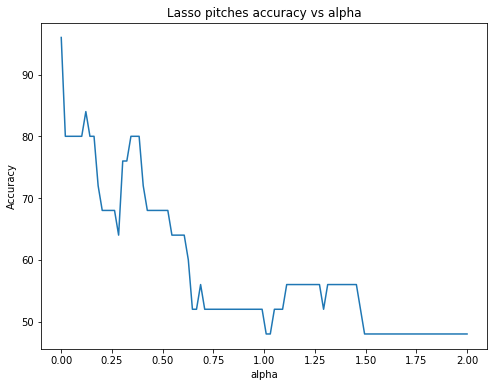

In [18]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Lasso pitches accuracy vs alpha")
plot_ = plt.plot(map(lambda x: x[1], fitted), map(lambda x: x[0], fitted))

Confusion matrix, without normalization
[[ 9  3]
 [ 0 10]]


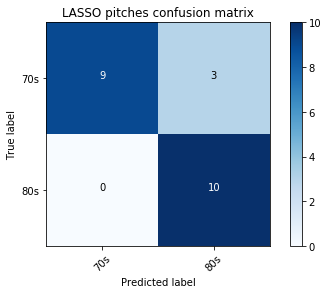

In [19]:
# Confusion matrix
Y_test
Y_predict = np.round(lassoreg.predict(X_test))
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=False,
                      title='LASSO pitches confusion matrix')

Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.    1.  ]]


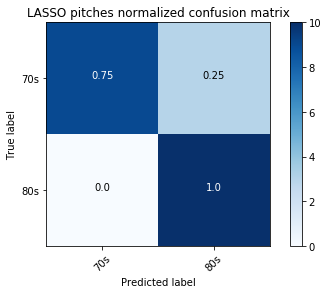

In [20]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=True,
                      title='LASSO pitches normalized confusion matrix')

# LASSO
## Durations

In [21]:
# Accessing durations
durationvector0, durationvector1 = get_vectors_from_pickles('durationfiles')

In [22]:
# Merging the vectors together and extracting the attributes and the label
X = durationvector0+durationvector1
Y = [0]*72+[1]*72

# Splitting the data into training and testing subsets 85 to 15 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state = 25)

# Splitting the training subset into training and validating subsets 80 to 20 %
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state = 25)

In [23]:
# Fitting the alpha
fitted = fitalpha()

/home/denis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator


In [24]:
# Looking for the optimal parameters
max(enumerate(fitted), key = lambda x: x[1])

(30, (64, 0.60606060606060608))

In [26]:
# Checkng on the test set
lassoreg = Lasso(alpha = 0.60606060606060608, normalize = False, max_iter = 1e5)
lassoreg.fit(X_train, Y_train)
print "We successfully predict the {} percent of training data".format((Y_train==np.round(lassoreg.predict(X_train))).sum()*100/len(Y_train))
print "We successfully predict the {} percent of test data".format((Y_test==np.round(lassoreg.predict(X_test))).sum()*100/len(Y_test))

We successfully predict the 73 percent of training data
We successfully predict the 50 percent of test data


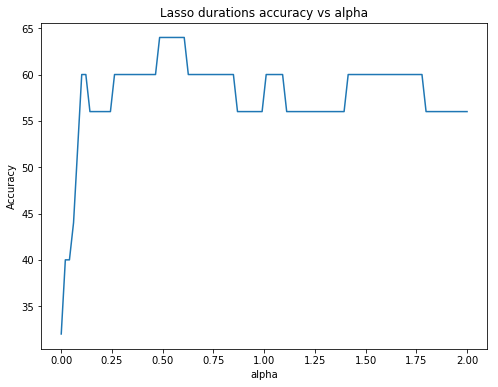

In [27]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Lasso durations accuracy vs alpha")
plot_ = plt.plot(map(lambda x: x[1], fitted), map(lambda x: x[0], fitted))

Confusion matrix, without normalization
[[8 4]
 [7 3]]


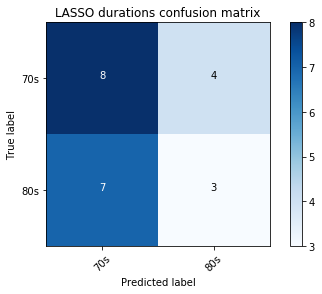

In [29]:
# Confusion matrix
Y_test
Y_predict = np.round(lassoreg.predict(X_test))
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=False,
                      title='LASSO durations confusion matrix')

Normalized confusion matrix
[[ 0.66666667  0.33333333]
 [ 0.7         0.3       ]]


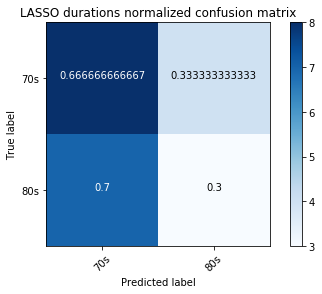

In [30]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_predict), classes=['70s', '80s'], normalize=True,
                      title='LASSO durations normalized confusion matrix')